In [1]:
#####
# This group of functions processes ICESAT2 data and creates a bathymetric model. 
# To do this, it follows a number of steps in the form of functions, including:
# 1. Reading data (ReadATL03())
# 2. Orthometrically correcting the dataset (OrthometricCorrection())
# 3. Pulling down the data segment ID (getAtl03SegID())
# 4. Bin the data along latitudinal and height gradients (bin_data())
# 5. Calculate sea height (get_sea_height())
# 6. Correct bathymetry surface for refraction (RefractionCorrection())
# 7. Calculate bathymetry height (get_bath_height())
# 8. Produce figures (produce_figures())
#####

In [2]:
import numpy as np
import h5py as h5
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path
import matplotlib.pyplot as plt
import pyproj
from pyproj import Proj
from pyproj import Transformer
import pandas as pd
import argparse
import os
import subprocess
import time

In [3]:
### Set parameters
# Define variables and location
data_path = '/Users/brian.h.lee/Desktop/icesat/data/raw/processed_ATL03_20210215034713_08121001_004_01.h5'
output_path = '/Users/brian.h.lee/Desktop/icesat/images'
laser_number = '3'
location = 'Bahamas'
epsg_code = 'epsg:32617'

# Set resolution (in m)
lat_resolution = 10
height_resolution = 0.5

# Set threshold parameter for selection of bathymetry point values
threshold_percentile = 38

In [4]:
def OrthometricCorrection(lat, lon, Z, epsg):
    # transform ellipsod (WGS84) height to orthometric height
    transformerh = Transformer.from_crs("epsg:4326", "epsg:3855")
    Y_egm08, X_egm08, Z_egm08 = transformerh.transform(lat, lon, Z)
    
    # transform WGS84 proj to local UTM
    myProj = Proj(epsg)
    Y_utm, X_utm = myProj(lat, lon)
    
    return Y_utm, X_utm, Z_egm08

def ReadATL03(h5_file, laser_num):
    # Read File
    f = h5.File(h5_file,'r')
    
    # Select a laser
    orientation = f['/orbit_info/sc_orient'][0]
    # selects the strong beams only [we can include weak beams later on]
    orientDict = {0:'l', 1:'r', 21:'error'}
    laser = 'gt' + laser_num + orientDict[orientation]
    
    # Read in the required photon level data
    photon_h = f['/' + laser + '/heights/h_ph'][...,]
    latitude = f['/' + laser + '/heights/lat_ph'][...,]
    longitude = f['/' + laser + '/heights/lon_ph'][...,]
    conf = f['/' + laser + '/heights/signal_conf_ph/'][...,0]

    # params needed for refraction correction
    
    ref_elev = f['/' + laser + '/geolocation/ref_elev'][...,]
    ref_azimuth = f['/' + laser + '/geolocation/ref_azimuth'][...,]
    ph_index_beg = f['/' + laser + '/geolocation/ph_index_beg'][...,]
    segment_id = f['/' + laser + '/geolocation/segment_id'][...,]
    
    return latitude, longitude, photon_h, conf, ref_elev, ref_azimuth, ph_index_beg, segment_id


def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("-i", "--input", type=str, help="Specify the input ICESAT H5 file")
    parser.add_argument("-l", "--laser", type=str, help="Specify the ICESAT-2 laser number (1, 2 or 3)")
    parser.add_argument("-e", "--epsg_num", type=int, help="Specify the UTM Zone EPSG code (www.spatialreference.org)")
    #parser.add_argument("-wt", "--waterTemp", type=float, help="Specify the water temperature in degrees C")
    
    args = parser.parse_args()
    
    if args.input == None:
        print('MISSING H5')
        os._exit(1)
    elif args.laser == None:
        print('MISSING LASER NUMBER')
        os._exit(1)
    elif args.epsg_num == None:
        print('MISSING UTM ZONE')
        os._exit(1)

    latitude, longitude, photon_h = ReadATL03(args.input, args.laser)
    
    lat_utm, lon_utm, photon_h = OrthometricCorrection(latitude, longitude, photon_h, args.epsg)

In [5]:
latitude, longitude, photon_h, conf, ref_elev, ref_azimuth, ph_index_beg, segment_id = ReadATL03(data_path, laser_number)
lat_utm, lon_utm, photon_h = OrthometricCorrection(latitude, longitude, photon_h, epsg_code)

In [6]:
# Snippet by Eric Guenther (via Amy N.) for assigning photons to a segment
def getAtl03SegID(atl03_ph_index_beg, atl03_segment_id, atl03_heights_len): 
    
    # We need to know spacecraft orbin info, which is provided across segments. This first function assigns photons to the segmenet they belong to. We end up making a new array
    # that has more points to match the photon. Segment is defined as every 100m in the long track.
    
    # Filter all data where atl03_ph_index starts at 0 (0 indicates errors)
    indsNotZero = atl03_ph_index_beg != 0
    atl03_ph_index_beg = atl03_ph_index_beg[indsNotZero]
    atl03_segment_id = atl03_segment_id[indsNotZero]
    
    # Subtract 1 from ph_index_beg to start at python 0th pos
    atl03_ph_index_beg = atl03_ph_index_beg - 1
    
    # Sometimes the ph_index_beg is not at the 0th position, it is is not,
    # add it in and then add the associated segment id
    # Warning, this is assuming that the segment id for the points are from
    # the segment id directly before it, this assumption might fail but I have
    # not come across a case yet where it does.  If you want to play it safe
    # you could comment this section out and then if the first position is not
    # 0 then all photons before the first position will not be assigned a
    # segment id.
    # if atl03_ph_index_beg[0] != 0:
    #     atl03_ph_index_beg = np.append(0,atl03_ph_index_beg)
    #     first_seg_id = atl03_segment_id[0] -1
    #     atl03_segment_id = np.append(first_seg_id,atl03_segment_id)
    
    
    # Append atl03_height_len to end of array for final position
    atl03_ph_index_beg = np.append(atl03_ph_index_beg,atl03_heights_len)
    
    # Make array equal to the length of the atl03_heights photon level data
    ph_segment_id = np.zeros(atl03_heights_len)
    
    # Iterate through ph_index_beg, from the first to second to last number
    # and set the photons between ph_index_beg i to ph_index_beg i + 1 to
    # segment id i
    for i in range(0,len(atl03_ph_index_beg) - 1):
        ph_segment_id[atl03_ph_index_beg[i]:atl03_ph_index_beg[i+1]] = atl03_segment_id[i]
    
    # Return list of segment_id at the photon level
    return ph_segment_id


In [7]:
###### Get ref-elev and ref_azimuth at photon level
# Get length of photon array
heights_len = len(photon_h)
# Assign segment id to each photon for the segment it is in
Ph_segment_id = getAtl03SegID(ph_index_beg, segment_id, heights_len)
# Cast as an int
Ph_segment_id = Ph_segment_id.astype(np.int)
# Ref_elev on a per photon level (assign seg ref_elev to photons)
Ph_ref_elev = ref_elev[np.searchsorted(segment_id, Ph_segment_id)]
# Ref_azimuth on a per photon level (assign seg ref_azimuth to photons)
Ph_ref_azimuth = ref_azimuth[np.searchsorted(segment_id, Ph_segment_id)]

In [8]:
# Aggregate data into dataframe
dataset_sea = pd.DataFrame({'latitude': lat_utm, 'longitude': lon_utm, 'photon_height': photon_h, 'confidence':conf, 'ref_elevation':Ph_ref_elev, 'ref_azminuth':Ph_ref_azimuth}, 
                       columns=['latitude', 'longitude', 'photon_height', 'confidence', 'ref_elevation', 'ref_azminuth'])

##### Filter data that should not be analyzed
# Filter for quality flags
dataset_sea1 = dataset_sea[(dataset_sea.confidence != 0)  & (dataset_sea.confidence != 1)]
# Filter for elevation range
dataset_sea1 = dataset_sea1[(dataset_sea1['photon_height'] > -40) & (dataset_sea1['photon_height'] < 5)]
# Focus on specific latitude
# dataset_sea1 = dataset_sea1[(dataset_sea1['latitude'] > 1300000) & (dataset_sea1['latitude'] < 1350000)]

In [9]:
def bin_data(dataset, lat_res, height_res):
    
    # Calculate number of bins required
    lat_bin_number = round(abs(dataset['latitude'].min() - dataset['latitude'].max())/lat_res)
    height_bin_number = round(abs(dataset['photon_height'].min() - dataset['photon_height'].max())/height_res)
    
    dataset1 = dataset
    # Cut lat bins
    lat_bins = pd.cut(dataset['latitude'], lat_bin_number, labels = np.array(range(lat_bin_number)))
    # Add bins to dataframe
    dataset1['lat_bins'] = lat_bins
    # Cut height bins
    height_bins = pd.cut(dataset['photon_height'], height_bin_number, labels = np.round(np.linspace(dataset['photon_height'].min(), dataset['photon_height'].max(), num=height_bin_number), decimals = 1))
    # Add height bins to dataframe
    dataset1['height_bins'] = height_bins
    dataset1 = dataset1.reset_index(drop=True)

    return dataset1

def get_sea_height(binned_data):
    # Create sea height list
    sea_height = []
    
    # Group data by latitude
    binned_data_sea = binned_data[(binned_data['photon_height'] > -1)] # Filter out subsurface data
    grouped_data = binned_data_sea.groupby(['lat_bins'], group_keys=True)
    data_groups = dict(list(grouped_data))
    
    # Loop through groups and return average sea height
    for k,v in data_groups.items():
        # Create new dataframe based on occurance of photons per height bin
        new_df = pd.DataFrame(v.groupby('height_bins').count())
        # Return the bin with the highest count
        largest_h_bin = new_df['latitude'].argmax()
        # Select the index of the bin with the highest count
        largest_h = new_df.index[largest_h_bin]
        # Calculate the median value of all values within this bin
        lat_bin_sea_median = v.loc[v['height_bins']==largest_h, 'photon_height'].median()
        # Append to sea height list
        sea_height.append(lat_bin_sea_median)
        del new_df
        
    # Filter out sea height bin values outside 1 SD of mean.
    mean = np.nanmean(sea_height, axis=0)
    sd = np.nanstd(sea_height, axis=0)
    sea_height_1 = np.where((sea_height > (mean + sd)) | (sea_height < (mean - sd)), np.nan, sea_height).tolist()
    
    return sea_height_1


In [10]:
binned_data_sea = bin_data(dataset_sea1, lat_resolution, height_resolution)
sea_height = get_sea_height(binned_data_sea)

In [11]:
def RefractionCorrection(WTemp, WSmodel, Wavelength, Photon_ref_elev, Ph_ref_azimuth, PhotonZ, PhotonX, PhotonY, Ph_Conf):
    
    # WTemp; there is python library that pulls water temp data 
    # WSmodel is the value surface height
    # Wavelength is fixed
    
    
    # Only process photons below water surface model
    PhotonX = PhotonX[PhotonZ<=WSmodel]
    PhotonY = PhotonY[PhotonZ<=WSmodel]
    Photon_ref_elev = Photon_ref_elev[PhotonZ<=WSmodel]
    Ph_ref_azimuth = Ph_ref_azimuth[PhotonZ<=WSmodel]
    Ph_Conf = Ph_Conf[PhotonZ<=WSmodel]
    PhotonZ = PhotonZ[PhotonZ<=WSmodel]
    
    # water temp for refraction correction
    WaterTemp= WTemp
    
    # Refraction coefficient #
    a = -0.000001501562500
    b = 0.000000107084865
    c = -0.000042759374989
    d = -0.000160475520686
    e = 1.398067112092424
    wl = Wavelength
    
    # refractive index of air
    n1 = 1.00029
    
    # refractive index of water
    n2 = (a*WaterTemp**2) + (b*wl**2) + (c*WaterTemp) + (d*wl) + e
    
    # assumption is 0.25416
    # This example is refractionCoef = 0.25449
    # 1.00029 is refraction of air constant
    CorrectionCoef = (1-(n1/n2))
    #########################
    
    #read photon ref_elev to get theta1
    theta1 = np.pi/2 - Photon_ref_elev
    
    # eq 1. Theta2
    theta2 = np.arcsin(((n1*np.sin(theta1))/n2))
    
    # eq 3. S
    # Approximate water Surface = 1.5
    # D  = raw uncorrected depth
    D = WSmodel - PhotonZ
    
    # For Triangle DTS
    S = D/np.cos(theta1)
    
    # eq 2. R
    R = (S*n1)/n2
    Gamma = (np.pi/2)-theta1
    
    # For triangle RPS
    # phi is an angle needed
    phi = theta1-theta2
    
    # P is the difference between raw and corrected YZ location
    P = np.sqrt(R**2 + S**2 - 2*R*S*np.cos(phi))
    
    # alpha is an angle needed
    alpha = np.arcsin((R*np.sin(phi))/P)
    
    # Beta angle needed for Delta Y an d Delta Z
    Beta = Gamma - alpha
    
    # Delta Y
    DY = P*np.cos(Beta)
    
    # Delta Z
    DZ = P*np.sin(Beta)
    
    # Delta Easting
    DE = DY*np.sin(Ph_ref_azimuth)
    
    # Delta Northing
    DN = DY*np.cos(Ph_ref_azimuth)
    
    outX = PhotonX + DE
    outY = PhotonY + DN
    outZ = PhotonZ + DZ
    '''
        print('\nFor selected Bathy photon:')
        print('lat = ', PhotonY[9000])
        print('long = ', PhotonX[9000])
        print('Raw Depth = ', PhotonZ[9000])
        print('D = ', D[9000])
        
        print('ref_elev = ', Photon_ref_elev[9000])
        
        print('Delta Easting = ', DE[9000])
        print('Delta Northing = ', DN[9000])
        print('Delta Z = ', DZ[9000])
        '''
    return(outX, outY, outZ, Ph_Conf, PhotonX, PhotonY, PhotonZ, Ph_ref_azimuth, Photon_ref_elev) # We are most interested in outx, outy, outz

In [12]:
# Set sea height
WSHeight = np.nanmedian(sea_height)
# Set sea temperature
waterTemp = 20

RefX, RefY, RefZ, RefConf, rawX, rawY, rawZ, ph_ref_azi, ph_ref_elev = RefractionCorrection(waterTemp, WSHeight, 532, dataset_sea1.ref_elevation, dataset_sea1.ref_azminuth, dataset_sea1.photon_height, dataset_sea1.longitude, dataset_sea1.latitude, dataset_sea1.confidence) # XYZ are what we're interested in .

# Create new dataframe with refraction corrected data
dataset_bath = pd.DataFrame({'latitude': rawY, 'longitude': rawX, 'cor_latitude':RefY, 'cor_longitude':RefX, 'cor_photon_height':RefZ, 'photon_height': rawZ, 'confidence':RefConf}, 
                       columns=['latitude', 'longitude', 'photon_height', 'cor_latitude','cor_longitude', 'cor_photon_height', 'confidence'])

In [13]:
binned_data = bin_data(dataset_bath, lat_resolution, height_resolution)

In [21]:
def get_bath_height(binned_data, percentile):
    # Create sea height list
    bath_height = []
    
    # Group data by latitude
    binned_data_bath = binned_data[(binned_data['photon_height'] < WSHeight - (height_resolution * 2))] # Filter out surface data that are two bins below median surface value calculated above
    grouped_data = binned_data_bath.groupby(['lat_bins'], group_keys=True)
    data_groups = dict(list(grouped_data))
    count_threshold = np.percentile(binned_data.groupby(['lat_bins', 'height_bins']).size().reset_index().groupby('lat_bins')[[0]].max(), percentile)
    
    # Loop through groups and return average sea height
    for k,v in data_groups.items():
        new_df = pd.DataFrame(v.groupby('height_bins').count())
        bath_bin = new_df['cor_latitude'].argmax()
        bath_bin_h = new_df.index[bath_bin]
        # Set threshold of photon counts per bin
        if new_df.iloc[bath_bin]['latitude'] >= count_threshold:
            bath_bin_median = v.loc[v['height_bins']==bath_bin_h, 'cor_photon_height'].median()
            bath_height.append(bath_bin_median)
            del new_df
            
        else:
            bath_height.append(np.nan)
            del new_df
    
    return bath_height

def produce_figures(binned_data, bath_height, sea_height, scene_location, y_limit_top, y_limit_bottom, file_destination, location):
    
    # Create bins for latitude
    x_axis_bins = np.linspace(binned_data.latitude.min(), binned_data.latitude.max(), len(sea_height))
    
    # Create new dataframes for median values
    bath_median_df = pd.DataFrame({'x':x_axis_bins, 'y':bath_height})
    
    # 
    sea_height1 = [np.nanmedian(sea_height) if i == i else np.nan for i in sea_height]
    sea_median_df = pd.DataFrame({'x':x_axis_bins, 'y':sea_height1})

    # Define figure size
    fig = plt.rcParams["figure.figsize"] = (40,5)
    
    # Plot raw points
#     plt.scatter(x=binned_data.latitude, y = binned_data.photon_height, marker='o', lw=0, s=1, alpha = 0.8, c = 'yellow', label = 'Raw photon height')
#     plt.scatter(x=binned_data.cor_latitude, y = binned_data.cor_photon_height, marker='o', lw=0, s=0.5, alpha = 0.3, c = 'black', label = 'Corrected photon height')

    # Plot median values
    plt.scatter(bath_median_df.x, bath_median_df.y, marker = 'o', c='r', alpha = 0.8, s = 5, label = 'Median bathymetry')
    plt.scatter(sea_median_df.x, sea_median_df.y, marker = 'o', c='b', alpha = 1, s = 0.5, label = 'Median sea surface')

    plt.title('Icesat2 Bathymetry\n' + location)
    plt.xlabel('Latitude')
    plt.ylabel('Photon H (in m)')

    plt.legend(loc="upper left")

    plt.xlim(left=binned_data.latitude.min(), right=binned_data.latitude.max())
    plt.ylim(top = y_limit_top, bottom = y_limit_bottom)
    
    timestr = time.strftime("%Y%m%d_%H%M%S")
    
    # Define where to save file
    plt.savefig(file_destination + '/' + scene_location + '_' + timestr + '.png')
    
    plt.show()
    
    plt.close()

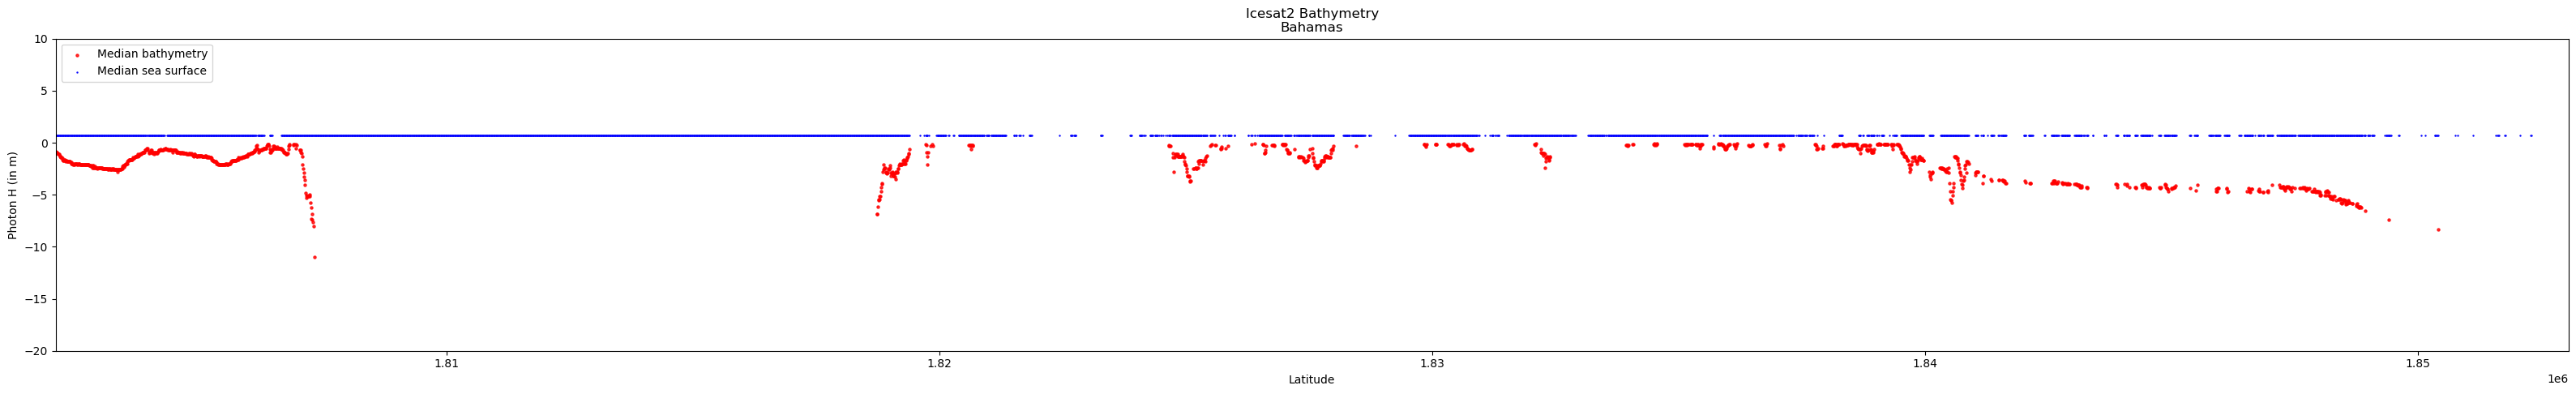

In [22]:
bath_height = get_bath_height(binned_data, threshold_percentile)
plt.close()
produce_figures(binned_data, bath_height, sea_height, 'Cuba', 10, -20, output_path, location)

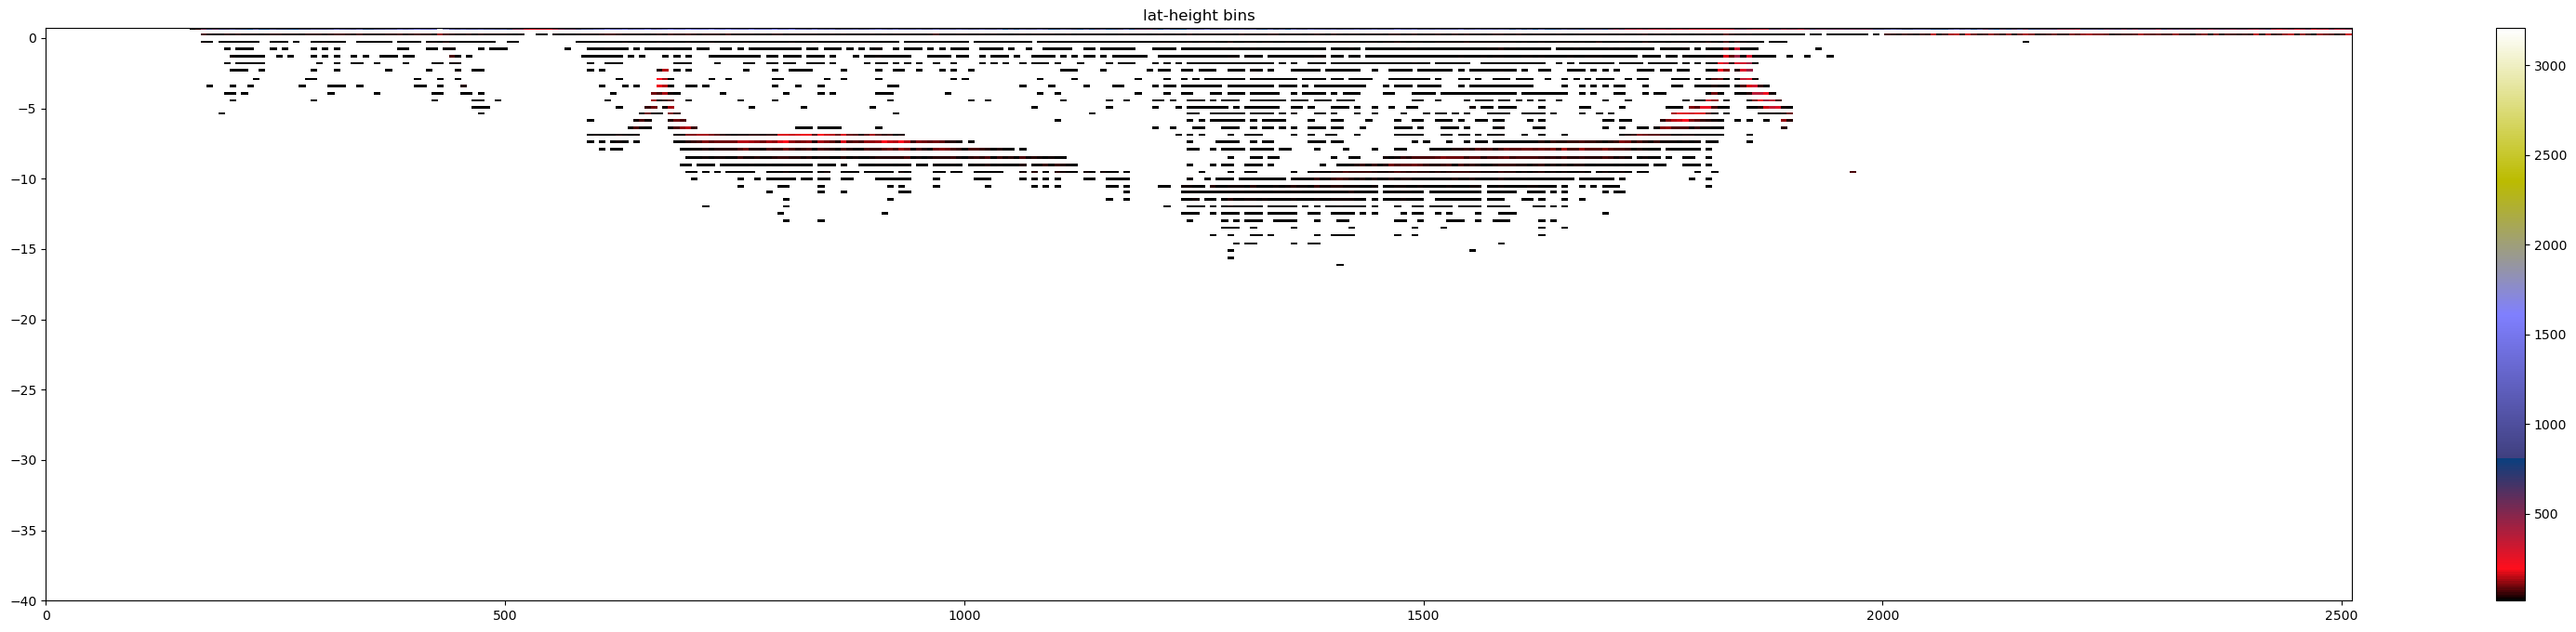

In [16]:
# fig, ax = plt.subplots(figsize=(40, 8))# Creating plot
# plt.hist2d(binned_data.lat_bins, binned_data.height_bins, bins = 400, cmin = 15, cmap = 'gist_stern')

# # ax.set_ylim([-10, 5])
# plt.title("lat-height bins")

# # show plot

# plt.colorbar()

# plt.show()

In [6]:
# def OrthometricCorrection(lat, lon, Z, epsg):
#     # transform ellipsod (WGS84) height to orthometric height
#     transformerh = Transformer.from_crs("epsg:4326", "epsg:3855")
#     Y_egm08, X_egm08, Z_egm08 = transformerh.transform(lat, lon, Z)
    
#     # transform WGS84 proj to local UTM
#     myProj = Proj(epsg)
#     Y_utm, X_utm = myProj(lat, lon)
    
#     return Y_utm, X_utm, Z_egm08

# def ReadATL03(h5_file, laser_num):
#     # Read File
#     f = h5.File(h5_file,'r')
    
#     # Select a laser
#     orientation = f['/orbit_info/sc_orient'][0]
#     # selects the strong beams only [we can include weak beams later on]
#     orientDict = {0:'l', 1:'r', 21:'error'}
#     laser = 'gt' + laser_num + orientDict[orientation]
    
#     # Read in the required photon level data
#     photon_h = f['/' + laser + '/heights/h_ph'][...,]
#     latitude = f['/' + laser + '/heights/lat_ph'][...,]
#     longitude = f['/' + laser + '/heights/lon_ph'][...,]
#     conf = f['/' + laser + '/heights/signal_conf_ph/'][...,0]

#     # params needed for refraction correction
    
#     ref_elev = f['/' + laser + '/geolocation/ref_elev'][...,]
#     ref_azimuth = f['/' + laser + '/geolocation/ref_azimuth'][...,]
#     ph_index_beg = f['/' + laser + '/geolocation/ph_index_beg'][...,]
#     segment_id = f['/' + laser + '/geolocation/segment_id'][...,]
    
#     return latitude, longitude, photon_h, conf, ref_elev, ref_azimuth, ph_index_beg, segment_id


# def main():
#     parser = argparse.ArgumentParser()
#     parser.add_argument("-i", "--input", type=str, help="Specify the input ICESAT H5 file")
#     parser.add_argument("-l", "--laser", type=str, help="Specify the ICESAT-2 laser number (1, 2 or 3)")
#     parser.add_argument("-e", "--epsg_num", type=int, help="Specify the UTM Zone EPSG code (www.spatialreference.org)")
#     #parser.add_argument("-wt", "--waterTemp", type=float, help="Specify the water temperature in degrees C")
    
#     args = parser.parse_args()
    
#     if args.input == None:
#         print('MISSING H5')
#         os._exit(1)
#     elif args.laser == None:
#         print('MISSING LASER NUMBER')
#         os._exit(1)
#     elif args.epsg_num == None:
#         print('MISSING UTM ZONE')
#         os._exit(1)

#     latitude, longitude, photon_h = ReadATL03(args.input, args.laser)
    
#     lat_utm, lon_utm, photon_h = OrthometricCorrection(latitude, longitude, photon_h, args.epsg)

# # Snippet by Eric Guenther (via Amy N.) for assigning photons to a segment
# def getAtl03SegID(atl03_ph_index_beg, atl03_segment_id, atl03_heights_len): 
    
#     # We need to know spacecraft orbin info, which is provided across segments. This first function assigns photons to the segmenet they belong to. We end up making a new array
#     # that has more points to match the photon. Segment is defined as every 100m in the long track.
    
#     # Filter all data where atl03_ph_index starts at 0 (0 indicates errors)
#     indsNotZero = atl03_ph_index_beg != 0
#     atl03_ph_index_beg = atl03_ph_index_beg[indsNotZero]
#     atl03_segment_id = atl03_segment_id[indsNotZero]
    
#     # Subtract 1 from ph_index_beg to start at python 0th pos
#     atl03_ph_index_beg = atl03_ph_index_beg - 1
    
#     # Sometimes the ph_index_beg is not at the 0th position, it is is not,
#     # add it in and then add the associated segment id
#     # Warning, this is assuming that the segment id for the points are from
#     # the segment id directly before it, this assumption might fail but I have
#     # not come across a case yet where it does.  If you want to play it safe
#     # you could comment this section out and then if the first position is not
#     # 0 then all photons before the first position will not be assigned a
#     # segment id.
#     # if atl03_ph_index_beg[0] != 0:
#     #     atl03_ph_index_beg = np.append(0,atl03_ph_index_beg)
#     #     first_seg_id = atl03_segment_id[0] -1
#     #     atl03_segment_id = np.append(first_seg_id,atl03_segment_id)
    
    
#     # Append atl03_height_len to end of array for final position
#     atl03_ph_index_beg = np.append(atl03_ph_index_beg,atl03_heights_len)
    
#     # Make array equal to the length of the atl03_heights photon level data
#     ph_segment_id = np.zeros(atl03_heights_len)
    
#     # Iterate through ph_index_beg, from the first to second to last number
#     # and set the photons between ph_index_beg i to ph_index_beg i + 1 to
#     # segment id i
#     for i in range(0,len(atl03_ph_index_beg) - 1):
#         ph_segment_id[atl03_ph_index_beg[i]:atl03_ph_index_beg[i+1]] = atl03_segment_id[i]
    
#     # Return list of segment_id at the photon level
#     return ph_segment_id


    
# def RefractionCorrection(WTemp, WSmodel, Wavelength, Photon_ref_elev, Ph_ref_azimuth, PhotonZ, PhotonX, PhotonY, Ph_Conf):
    
#     # WTemp; there is python library that pulls water temp data 
#     # WSmodel is the value surface height
#     # Wavelength is fixed
    
    
#     # Only process photons below water surface model
#     PhotonX = PhotonX[PhotonZ<=WSmodel]
#     PhotonY = PhotonY[PhotonZ<=WSmodel]
#     Photon_ref_elev = Photon_ref_elev[PhotonZ<=WSmodel]
#     Ph_ref_azimuth = Ph_ref_azimuth[PhotonZ<=WSmodel]
#     Ph_Conf = Ph_Conf[PhotonZ<=WSmodel]
#     PhotonZ = PhotonZ[PhotonZ<=WSmodel]
    
#     # water temp for refraction correction
#     WaterTemp= WTemp
    
#     # Refraction coefficient #
#     a = -0.000001501562500
#     b = 0.000000107084865
#     c = -0.000042759374989
#     d = -0.000160475520686
#     e = 1.398067112092424
#     wl = Wavelength
    
#     # refractive index of air
#     n1 = 1.00029
    
#     # refractive index of water
#     n2 = (a*WaterTemp**2) + (b*wl**2) + (c*WaterTemp) + (d*wl) + e
    
#     # assumption is 0.25416
#     # This example is refractionCoef = 0.25449
#     # 1.00029 is refraction of air constant
#     CorrectionCoef = (1-(n1/n2))
#     #########################
    
#     #read photon ref_elev to get theta1
#     theta1 = np.pi/2 - Photon_ref_elev
    
#     # eq 1. Theta2
#     theta2 = np.arcsin(((n1*np.sin(theta1))/n2))
    
#     # eq 3. S
#     # Approximate water Surface = 1.5
#     # D  = raw uncorrected depth
#     D = WSmodel - PhotonZ
    
#     # For Triangle DTS
#     S = D/np.cos(theta1)
    
#     # eq 2. R
#     R = (S*n1)/n2
#     Gamma = (np.pi/2)-theta1
    
#     # For triangle RPS
#     # phi is an angle needed
#     phi = theta1-theta2
    
#     # P is the difference between raw and corrected YZ location
#     P = np.sqrt(R**2 + S**2 - 2*R*S*np.cos(phi))
    
#     # alpha is an angle needed
#     alpha = np.arcsin((R*np.sin(phi))/P)
    
#     # Beta angle needed for Delta Y an d Delta Z
#     Beta = Gamma - alpha
    
#     # Delta Y
#     DY = P*np.cos(Beta)
    
#     # Delta Z
#     DZ = P*np.sin(Beta)
    
#     # Delta Easting
#     DE = DY*np.sin(Ph_ref_azimuth)
    
#     # Delta Northing
#     DN = DY*np.cos(Ph_ref_azimuth)
    
#     outX = PhotonX + DE
#     outY = PhotonY + DN
#     outZ = PhotonZ + DZ
#     '''
#         print('\nFor selected Bathy photon:')
#         print('lat = ', PhotonY[9000])
#         print('long = ', PhotonX[9000])
#         print('Raw Depth = ', PhotonZ[9000])
#         print('D = ', D[9000])
        
#         print('ref_elev = ', Photon_ref_elev[9000])
        
#         print('Delta Easting = ', DE[9000])
#         print('Delta Northing = ', DN[9000])
#         print('Delta Z = ', DZ[9000])
#         '''
#     return(outX, outY, outZ, Ph_Conf, PhotonX, PhotonY, PhotonZ, Ph_ref_azimuth, Photon_ref_elev) # We are most interested in outx, outy, outz



    
# def bin_data(dataset, lat_res, height_res):
    
#     # Calculate number of bins required
#     lat_bin_number = round(abs(dataset['latitude'].min() - dataset['latitude'].max())/lat_res)
#     height_bin_number = round(abs(dataset['photon_height'].min() - dataset['photon_height'].max())/height_res)
    
#     # Add bins to dataset
#     dataset1 = dataset
#     lat_bins = pd.cut(dataset['latitude'], lat_bin_number, labels = np.array(range(lat_bin_number)))
#     dataset1['lat_bins'] = lat_bins
#     height_bins = pd.cut(dataset['photon_height'], height_bin_number, labels = np.round(np.linspace(dataset['photon_height'].min(), dataset['photon_height'].max(), num=height_bin_number), decimals = 1))
#     dataset1['height_bins'] = height_bins
#     dataset1 = dataset1.reset_index(drop=True)

#     return dataset1

# def get_sea_height(binned_data):
#     # Create sea height list
#     sea_height = []
    
#     # Group data by latitude
#     binned_data_sea = binned_data[(binned_data['photon_height'] > -1)] # Filter out subsurface data
#     grouped_data = binned_data_sea.groupby(['lat_bins'], group_keys=True)
#     data_groups = dict(list(grouped_data))
    
#     # Loop through groups and return average sea height
#     for k,v in data_groups.items():
#         new_df = pd.DataFrame(v.groupby('height_bins').count())
#         largest_h_bin = new_df['latitude'].argmax()
#         largest_h = new_df.index[largest_h_bin]
#         lat_bin_sea_median = v.loc[v['height_bins']==largest_h, 'photon_height'].median()
#         sea_height.append(lat_bin_sea_median)
#         del new_df
    
#     return sea_height

# def get_bath_height(binned_data):
#     # Create sea height list
#     bath_height = []
    
#     # Group data by latitude
#     binned_data_bath = binned_data[(binned_data['photon_height'] < 0)] # Filter out surface data
#     grouped_data = binned_data_bath.groupby(['lat_bins'], group_keys=True)
#     data_groups = dict(list(grouped_data))
    
#     # Loop through groups and return average sea height
#     for k,v in data_groups.items():
#         new_df = pd.DataFrame(v.groupby('height_bins').count())
# #         new_df.drop(new_df.tail(2).index,inplace=True) # drop last 2 rows to filter out positive/above-sea-level bins 
#         sec_largest_h_bin = new_df['latitude'].argmax()
#         sec_largest_h = new_df.index[sec_largest_h_bin]
#         lat_bin_bath_median = v.loc[v['height_bins']==sec_largest_h, 'cor_photon_height'].median()
#         bath_height.append(lat_bin_bath_median)
#         del new_df
    
#     return bath_height

# def produce_figures(binned_data, bath_height, sea_height, scene_location, y_limit_top, y_limit_bottom, file_destination):
#     x_axis_bins = np.linspace(binned_data.latitude.min(), binned_data.latitude.max(), len(sea_height))
#     bath_median_df = pd.DataFrame({'x':x_axis_bins, 'y':bath_height})
#     sea_median_df = pd.DataFrame({'x':x_axis_bins, 'y':sea_height})
    
#     # # Subset scatter with cleaned data

#     fig = plt.rcParams["figure.figsize"] = (40,10)
# #     plt.scatter(x=binned_data.latitude, y = binned_data.photon_height, marker='o', lw=0, s=1, alpha = 0.8, c = 'yellow', label = 'Raw photon height')
# #     plt.scatter(x=binned_data.cor_latitude, y = binned_data.cor_photon_height, marker='o', lw=0, s=5, alpha = 0.2, c = 'r', label = 'Corrected photon height')


#     plt.scatter(bath_median_df.x, bath_median_df.y, marker = 'o', c='r', alpha = 0.8, s = 0.5, label = 'Median bathymetry')
#     plt.scatter(sea_median_df.x, sea_median_df.y, marker = 'o', c='b', alpha = 1, s = 0.5, label = 'Median sea surface')

#     location = 'cuba'

#     plt.title('Icesat2 Bathymetry\n' + location)
#     plt.xlabel('Latitude')
#     plt.ylabel('Photon H (in m)')

#     plt.legend(loc="upper left")

#     plt.xlim(left=binned_data.latitude.min(), right=binned_data.latitude.max())
#     plt.ylim(top = y_limit_top, bottom = y_limit_bottom)
    
#     timestr = time.strftime("%Y%m%d_%H%M%S")
#     plt.savefig(file_destination + '/' + scene_location + '_' + timestr + '.png')
    
#     plt.show()
    
#     plt.close()
    

# os.chdir('../data/raw')

# latitude, longitude, photon_h, conf, ref_elev, ref_azimuth, ph_index_beg, segment_id = ReadATL03('processed_ATL03_20200312201759_11780601_004_01.h5', '1')
# lat_utm, lon_utm, photon_h = OrthometricCorrection(latitude, longitude, photon_h, 'epsg:32617')

# ###### Get ref-elev and ref_azimuth at photon level
# # Get length of photon array
# heights_len = len(photon_h)
# # Assign segment id to each photon for the segment it is in
# Ph_segment_id = getAtl03SegID(ph_index_beg, segment_id, heights_len)
# # Cast as an int
# Ph_segment_id = Ph_segment_id.astype(np.int)

# # Ref_elev on a per photon level (assign seg ref_elev to photons)
# Ph_ref_elev = ref_elev[np.searchsorted(segment_id, Ph_segment_id)]
# # Ref_azimuth on a per photon level (assign seg ref_azimuth to photons)
# Ph_ref_azimuth = ref_azimuth[np.searchsorted(segment_id, Ph_segment_id)]

# # Find sea height
# lat_resolution = 10
# height_resolution = 0.25

# dataset_sea = pd.DataFrame({'latitude': lat_utm, 'longitude': lon_utm, 'photon_height': photon_h, 'confidence':conf, 'ref_elevation':Ph_ref_elev, 'ref_azminuth':Ph_ref_azimuth}, 
#                        columns=['latitude', 'longitude', 'photon_height', 'confidence', 'ref_elevation', 'ref_azminuth'])

# dataset_sea1 = dataset_sea[(dataset_sea.confidence != 0)  & (dataset_sea.confidence != 1)]
# dataset_sea1 = dataset_sea1[(dataset_sea1['photon_height'] > -30) & (dataset_sea1['photon_height'] < 5)]
# dataset_sea1 = dataset_sea1[(dataset_sea1['latitude'] > 1339000) & (dataset_sea1['latitude'] < 1350400)]
# binned_data_sea = bin_data(dataset_sea1, lat_resolution, height_resolution)
# sea_height = get_sea_height(binned_data_sea)

# # Auto method
# WSHeight = np.nanmedian(sea_height)
# waterTemp = 20

# RefX, RefY, RefZ, RefConf, rawX, rawY, rawZ, ph_ref_azi, ph_ref_elev = RefractionCorrection(waterTemp, WSHeight, 532, dataset_sea1.ref_elevation, dataset_sea1.ref_azminuth, dataset_sea1.photon_height, dataset_sea1.longitude, dataset_sea1.latitude, dataset_sea1.confidence) # XYZ are what we're interested in .

# dataset_bath = pd.DataFrame({'latitude': rawY, 'longitude': rawX, 'cor_latitude':RefY, 'cor_longitude':RefX, 'cor_photon_height':RefZ, 'photon_height': rawZ, 'confidence':RefConf}, 
#                        columns=['latitude', 'longitude', 'photon_height', 'cor_latitude','cor_longitude', 'cor_photon_height', 'confidence'])
# # dataset_bath1 = dataset_bath[(dataset_bath.confidence != 0)  & (dataset_bath.confidence != 1)]
# # dataset_bath1test = dataset_bath1[(dataset_bath1['latitude'] > 1349000) & (dataset_bath1['latitude'] < 1349900)]
# # dataset_test = dataset_test[(dataset_test['photon_height'] > -20) & (dataset_test['photon_height'] < 5)]


# binned_data = bin_data(dataset_bath, lat_resolution, height_resolution)
# bath_height = get_bath_height(binned_data)

# produce_figures(binned_data, bath_height, sea_height, 'Cuba', 10, -10, os.getcwd())